# Data Preprocessing and Manipulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

df_production = pd.read_csv("production.csv")
df_weather = pd.read_csv("weather_info.csv")
df_weather = df_weather[df_weather["date"] <= "2024-05-26"]

df_weather = df_weather.sort_values(by=["date", "hour", "lat", "lon"], ascending=[True, True, True, True])

# Check for missing values
missing_values = df_weather.isnull().sum()

# replace NaN
def mean_replace_nan(feature):
    arr = df_weather[feature].values
    new_arr = []
    length = len(arr)
    for idx, val in enumerate(arr):
        if pd.isna(val):
            # cover edge cases
            if idx - 25 < 0:
                # value for the same lat and lon 1 hour after
                new_arr.append(arr[idx + 25])
            elif idx + 25 > length - 1:
                # value for the same lat and lon 1 hour ago
                new_arr.append(arr[idx - 25])
            else:
                # take the mean
                new_arr.append((arr[idx - 25] + arr[idx + 25]) / 2)
        else:
            new_arr.append(val)
    return new_arr

# get the features that contain NaN
features_with_missing_values = [col for col in df_weather.columns if df_weather[col].isnull().any()]
# use above function to replace NaN with mean values
for feature in features_with_missing_values:
    new_arr = mean_replace_nan(feature)
    df_weather[feature] = new_arr

df_weather = df_weather[(df_weather["date"] <= "2024-05-26") & (df_weather["date"] > "2022-01-01")]
df_production = df_production[df_production["date"] > "2022-01-01"]

# removing duplicate values
df_production = df_production.drop_duplicates(subset=["date", "hour"])

# selecting the closest location for forecasts
df_weather_arima = df_weather[(df_weather["lat"] == 38.25) & (df_weather["lon"] == 35)]
df_merged = pd.merge(df_weather_arima, df_production, on=["date", "hour"])


columns_to_standardize = ['dswrf_surface', 'tcdc_low.cloud.layer', 'tcdc_middle.cloud.layer',
                          'tcdc_entire.atmosphere', 'uswrf_top_of_atmosphere',
                          'csnow_surface', 'dlwrf_surface', 'uswrf_surface', 'tmp_surface']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns

df_merged[columns_to_standardize] = scaler.fit_transform(df_merged[columns_to_standardize])

# Dropping the unnecessary lat and lon features
df_merged.drop(columns=["lat", "lon"], inplace=True)
df_merged['datetime'] = pd.to_datetime(df_merged['date'] + ' ' + df_merged['hour'].astype(str) + ':00:00')
binary_month = pd.get_dummies(df_merged.datetime.dt.month, prefix='month').astype(int)
df_merged = pd.concat([df_merged, binary_month], axis=1)
#df_merged = pd.concat([df_merged, binary_hour], axis=1)
df_merged.drop(columns=["tcdc_high.cloud.layer"], inplace=True)

df_merged

,date,hour,dswrf_surface,tcdc_low.cloud.layer,tcdc_middle.cloud.layer,tcdc_entire.atmosphere,uswrf_top_of_atmosphere,csnow_surface,dlwrf_surface,uswrf_surface,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2022-01-02,0,-0.798497,2.085578,2.063201,1.273121,-0.835520,-0.188175,-0.109158,-0.757090,...,0,0,0,0,0,0,0,0,0,0
1,2022-01-02,1,-0.798497,2.121407,2.063201,1.273121,-0.835520,-0.188175,-0.090943,-0.757090,...,0,0,0,0,0,0,0,0,0,0
2,2022-01-02,2,-0.798497,2.172165,2.063201,1.273121,-0.835520,-0.188175,0.022903,-0.757090,...,0,0,0,0,0,0,0,0,0,0
3,2022-01-02,3,-0.798497,2.205008,2.063201,1.273121,-0.835520,-0.188175,0.134061,-0.757090,...,0,0,0,0,0,0,0,0,0,0
4,2022-01-02,4,-0.798497,2.375196,1.841549,1.273121,-0.835520,5.314190,0.768226,-0.757090,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21019,2024-05-26,19,0.527159,0.315025,0.629303,0.755785,1.131216,-0.188175,1.160264,0.386232,...,0,0,1,0,0,0,0,0,0,0
21020,2024-05-26,20,0.266872,0.727059,0.916630,0.859252,0.827762,-0.188175,1.284720,0.161586,...,0,0,1,0,0,0,0,0,0,0
21021,2024-05-26,21,0.089330,1.001749,1.108181,0.929798,0.550548,-0.188175,1.348837,0.008353,...,0,0,1,0,0,0,0,0,0,0
21022,2024-05-26,22,-0.798497,2.369225,2.060465,1.270769,-0.835520,-0.188175,1.266869,-0.757090,...,0,0,1,0,0,0,0,0,0,0


# Helper functions:

A data getter and a post-forecast data processor that flattens data

In [5]:
# data getter
def get_hourly_data(hour, isTest=False):
    df_hour = df_merged[df_merged["hour"] == hour]
    df_hour.reset_index(drop=True, inplace=True)

    if isTest:
        df_test = df_hour[(df_hour["date"] >= "2024-02-01") & (df_hour["date"] <= "2024-05-15")]
        df_train = df_hour[df_hour["date"] < "2024-02-01"]
    else:
        df_test = df_hour[(df_hour["date"] >= "2024-04-12") & (df_hour["date"] < "2024-05-13")]
        df_train = df_hour[df_hour["date"] < "2024-04-12"]

    y_date_train= df_train.date
    y_date_test = df_test.date
    y_train = np.array(df_train.production)
    y_test = np.array(df_test.production)
    df_train.drop(columns=['date', 'hour', 'production', 'datetime'], inplace=True)
    df_test.drop(columns=['date', 'hour', 'production', 'datetime'], inplace=True)
    return df_train, df_test, y_train, y_test

def flatten_forecast(forecasts):
    flattened_forecasts = []
    length = len(forecasts)
    days = len(forecasts[0])
    for i in range(days):
        # hours 0, 1, 2, 3, 4
        initial_list = [0, 0, 0, 0, 0]
        for j in range(length):
            initial_list.append(forecasts[j][i])
        # hours 22 and 23
        initial_list.extend([0, 0])
        flattened_forecasts.extend(initial_list)
    return flattened_forecasts

# Grid Search for best possible common p, d, q pair

In [4]:
def remove_constant_column(exog):
    # Check if the exog data has a constant column and remove it
    if np.all(exog == 1, axis=0).any():
        exog = exog[:, np.all(exog != 1, axis=0)]
    return exog

# search space for AR, MA, d values
max_ar, max_ma, max_d = 3, 3, 2
for hour in range(5, 22):
    df_train, df_test, y_train, y_test = get_hourly_data(hour)
    
    # Remove constant columns
    df_train = remove_constant_column(df_train.values)
    df_test = remove_constant_column(df_test.values)
    
    forecast_steps = len(list(y_test))
    weights = y_test / y_test.sum()
    print(10*"=", f"HOUR {hour}", 10*"=")
    
    # grid search
    for ar in range(max_ar):
        for ma in range(max_ma):
            for d in range(max_d):
                arima = ARIMA(y_train, exog=df_train, order=(ar, d, ma), trend='n')
                res = arima.fit()
                forecast = res.forecast(steps=forecast_steps, exog=df_test)
                weighted_mpae = mean_absolute_percentage_error(y_test, forecast, sample_weight=weights)
                print(f"AR({ar}) | MA({ma}) | d({d}) | WMAPE = {round(weighted_mpae, 3)}")

========== HOUR 5 ==========
AR(0) | MA(0) | d(0) | WMAPE = 0.94
AR(0) | MA(0) | d(1) | WMAPE = 0.631
AR(0) | MA(1) | d(0) | WMAPE = 0.955
AR(0) | MA(1) | d(1) | WMAPE = 0.328
AR(0) | MA(2) | d(0) | WMAPE = 0.941
AR(0) | MA(2) | d(1) | WMAPE = 0.302
AR(1) | MA(0) | d(0) | WMAPE = 0.912
AR(1) | MA(0) | d(1) | WMAPE = 0.442
AR(1) | MA(1) | d(0) | WMAPE = 0.457
AR(1) | MA(1) | d(1) | WMAPE = 0.302
AR(1) | MA(2) | d(0) | WMAPE = 0.334
AR(1) | MA(2) | d(1) | WMAPE = 0.338
AR(2) | MA(0) | d(0) | WMAPE = 0.748
AR(2) | MA(0) | d(1) | WMAPE = 0.438
AR(2) | MA(1) | d(0) | WMAPE = 0.63
AR(2) | MA(1) | d(1) | WMAPE = 0.287
AR(2) | MA(2) | d(0) | WMAPE = 0.333
AR(2) | MA(2) | d(1) | WMAPE = 0.289
========== HOUR 6 ==========
AR(0) | MA(0) | d(0) | WMAPE = 0.702
AR(0) | MA(0) | d(1) | WMAPE = 0.196
AR(0) | MA(1) | d(0) | WMAPE = 0.703
AR(0) | MA(1) | d(1) | WMAPE = 0.192
AR(0) | MA(2) | d(0) | WMAPE = 0.679
AR(0) | MA(2) | d(1) | WMAPE = 0.178
AR(1) | MA(0) | d(0) | WMAPE = 0.656
AR(1) | MA(0) | d(1

# Testing the pair with ACF & PACF plots


HOUR 5



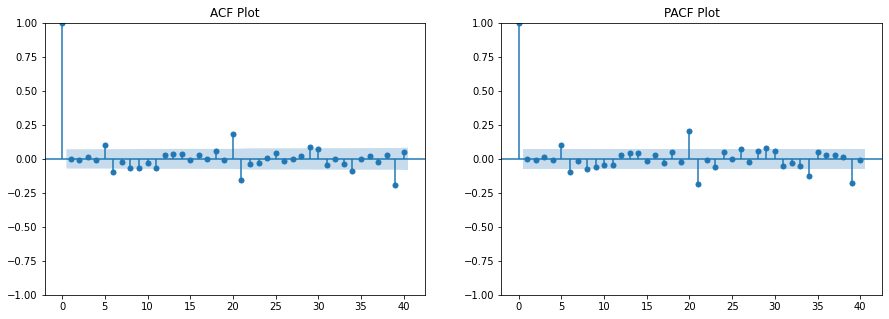


HOUR 6



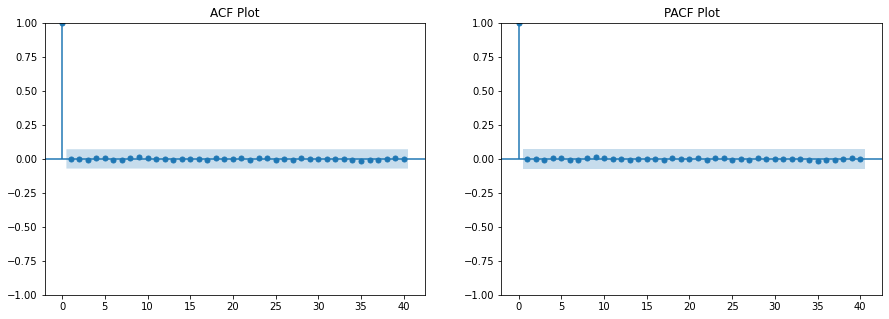


HOUR 7



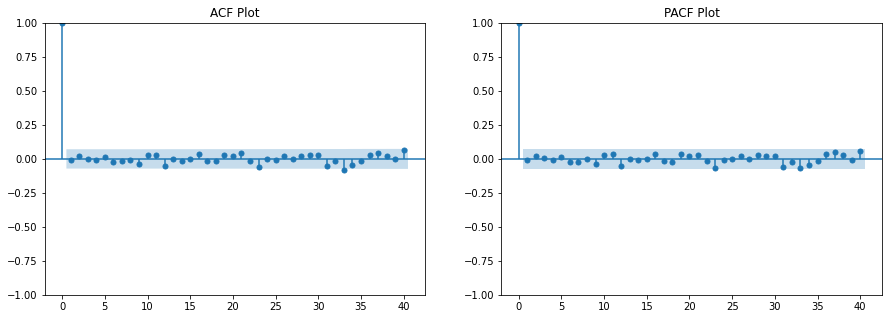


HOUR 8



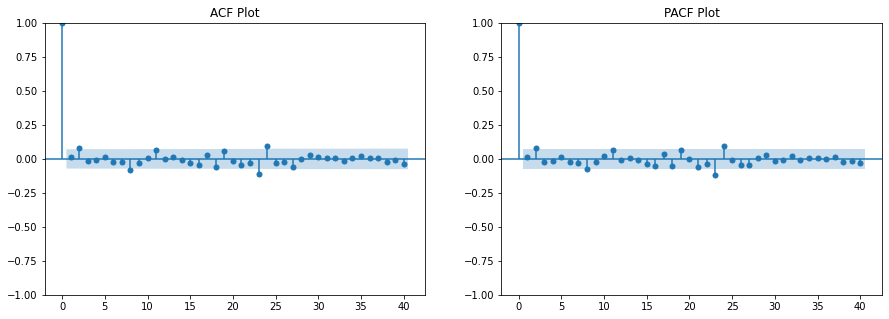


HOUR 9



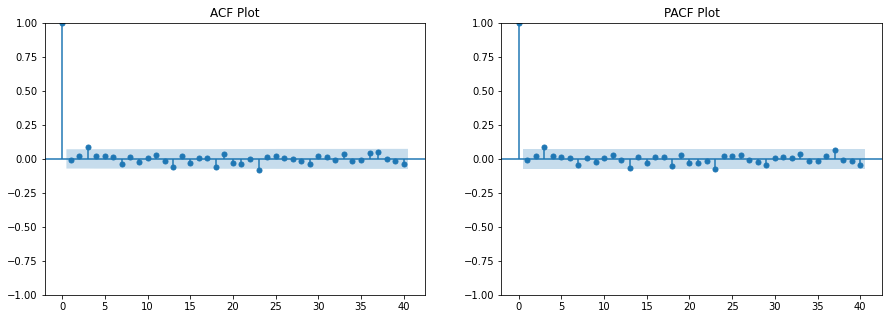


HOUR 10



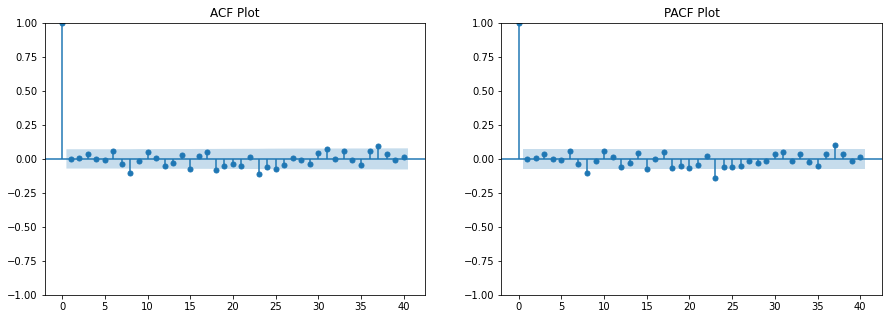


HOUR 11



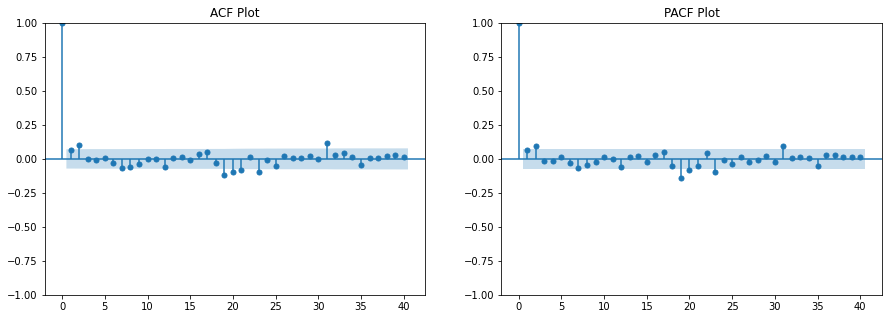


HOUR 12



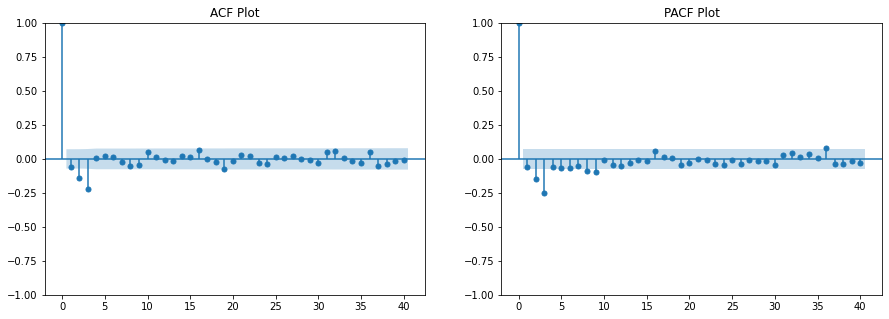


HOUR 13



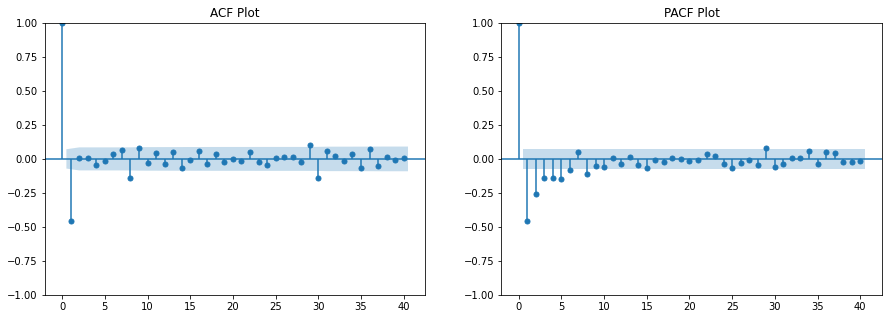


HOUR 14



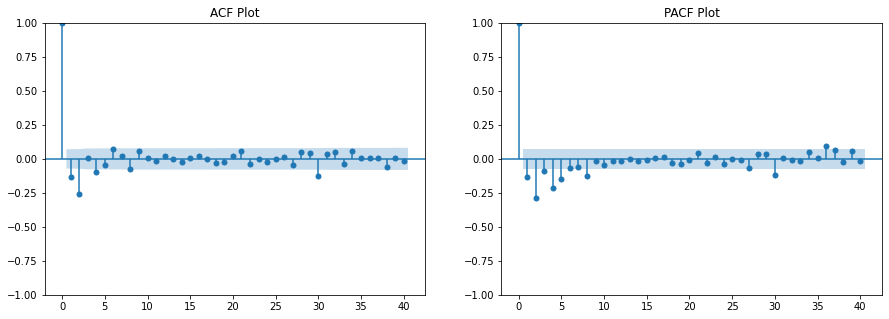


HOUR 15



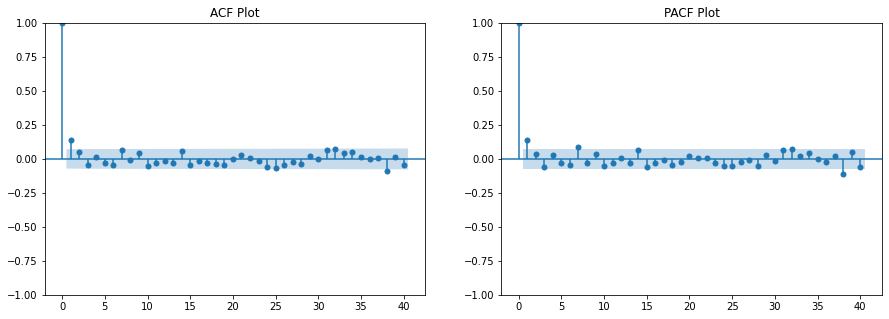


HOUR 16



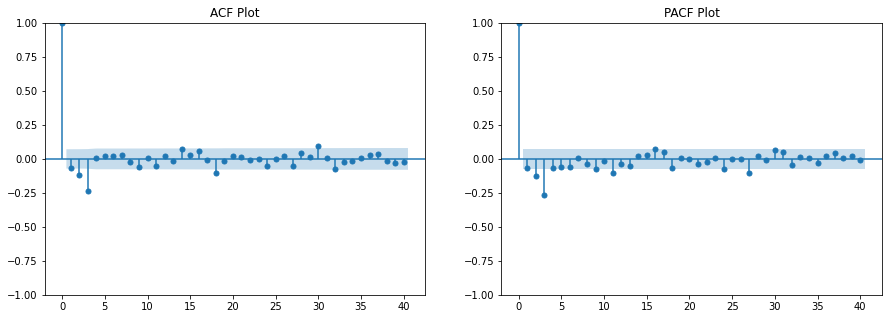


HOUR 17



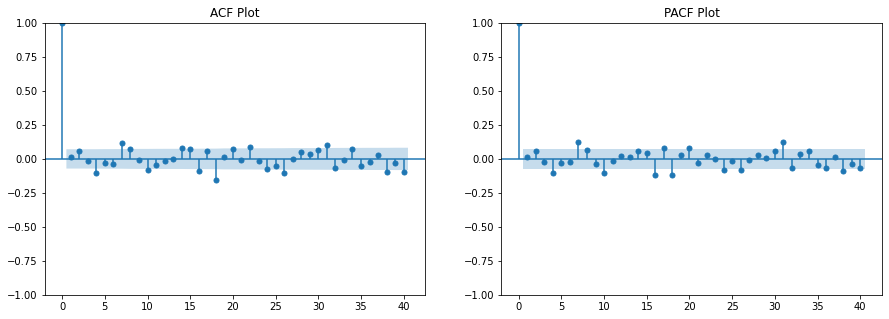


HOUR 18



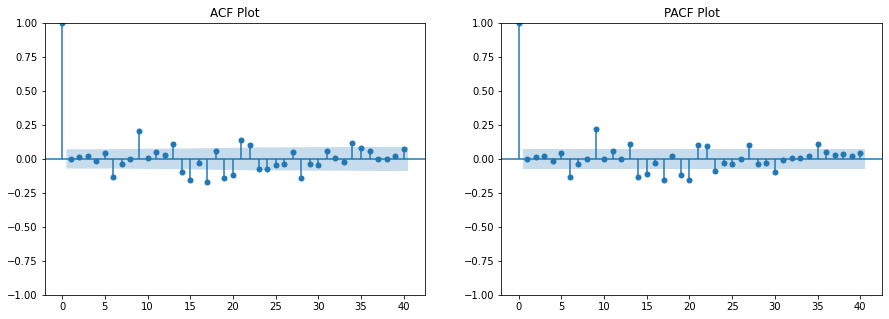


HOUR 19



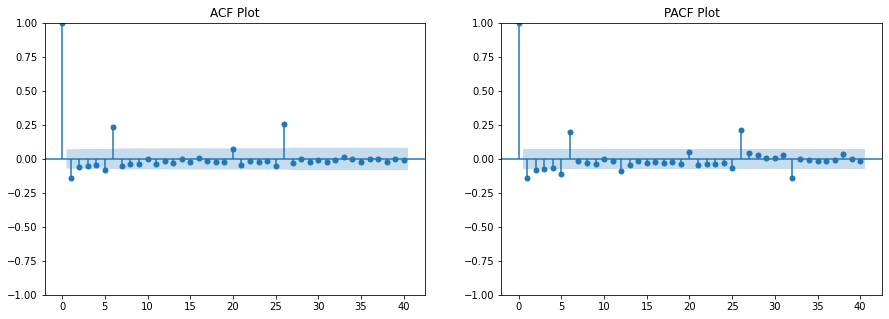


HOUR 20



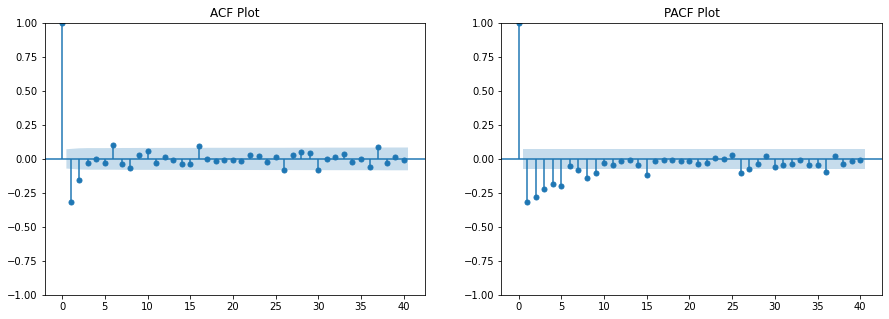


HOUR 21



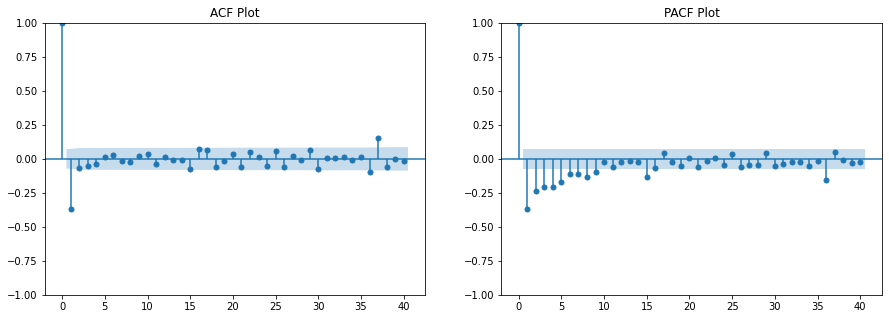

In [6]:
arima_mapping = {
    5: (2,1,2),
    6: (2,1,2),
    7: (2,1,2),
    8: (0,1,2),
    9: (2,1,2),
    10: (2,1,1),
    11: (0,1,1),
    12: (2,1,0),
    13: (0,1,0),
    14: (1,1,0),
    15: (0,1,1),
    16: (2,1,0),
    17: (0,1,2),
    18: (0,1,2),
    19: (0,1,2),
    20: (0,1,2),
    21: (0,1,2)
}
forecasts = []
for hour in range(5, 22):
    print("\n" + 10*"=", f"\nHOUR {hour}\n", 10*"=" + "\n")
    df_train, df_test, y_train, y_test = get_hourly_data(hour, isTest=True)
    forecast_steps = len(list(y_test))
    ar, d, ma = arima_mapping[hour]
    arima = ARIMA(y_train, exog=df_train.values, order=(ar, d, ma))
    res = arima.fit()
    forecast = res.forecast(steps=forecast_steps, exog=df_test.values)
    # get the results for test period, 13-26 may
    forecasts.append(list(forecast)[-14:])
    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # ACF plot
    plot_acf(res.resid, ax=axes[0], lags=40)
    axes[0].set_title('ACF Plot')

    # PACF plot
    plot_pacf(res.resid, ax=axes[1], lags=40)
    axes[1].set_title('PACF Plot')
    plt.show()